In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.express as px

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

Durante la exposición, se Durante la exposición, se debería tocar, al menos, los siguientes temas:
- Exordio (saludo, me presento, credenciales, tema y división de ideas).
- Narración en la que se incluya:
    - Breve descripción de la ciudad.
- Estudio por vecindarios (algunas ciudades, como Londres, tienen problemas en este punto).
    -  Mapa de localizaciones.
    -  Tipo de habitaciones y propiedades disponibles.
    -  Valoración sobre los superhost.
    -  Precios medios por vecindario.
    -  Seguridad por vecindario (esta información os tocará buscarla).
    -  Análisis de las reviews (limpieza, precisión, valor, comunicación, ubicación, etc).
    - Disponibilidad en el tiempo.
    - Minería de texto de las reviews.
- Peroración (recapitulación de ideas, recordatorio del tema, frase/dato impactante, agradecimientos y despedida).


In [2]:
listings = pd.read_csv("Input/listings.csv", index_col= "id")
listings_details = pd.read_csv("Input/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("Input/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("Input/reviews_details.csv", parse_dates=['date'])

In [3]:
reviews = pd.read_csv("Input/reviews.csv", parse_dates=['date'])

In [4]:
len(listings_details.columns)

74

In [5]:
pd.set_option('display.max_columns', None)


In [6]:
listings_details.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

In [7]:
listings_details['neighbourhood_group_cleansed']

id
2737                 NaN
3079                 NaN
103245               NaN
11834                NaN
103870               NaN
                      ..
973114587147200878   NaN
973116672976730965   NaN
973122317695245605   NaN
973124076276156534   NaN
973135638564147423   NaN
Name: neighbourhood_group_cleansed, Length: 28014, dtype: float64

In [8]:
listings_details = listings_details[['host_id','accommodates',
 'host_since', 'host_location', 
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'latitude',
       'longitude', 'property_type', 'room_type',
        'bedrooms','price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365','number_of_reviews','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']]

In [9]:
len(listings_details.columns)

35

In [10]:
print(listings.shape)
print(listings_details.shape)


(28014, 17)
(28014, 35)


In [11]:
# Hacemos un merge entre listing y listings_details, ya que lisitngs es un resumen para visualizaciones

listings = pd.merge(listings, listings_details, on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28014 entries, 2737 to 975133475180631768
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          28014 non-null  object 
 1   host_id_x                                     28014 non-null  int64  
 2   host_name                                     28014 non-null  object 
 3   neighbourhood_group                           0 non-null      float64
 4   neighbourhood                                 28014 non-null  object 
 5   latitude_x                                    28014 non-null  float64
 6   longitude_x                                   28014 non-null  float64
 7   room_type_x                                   28014 non-null  object 
 8   price_x                                       28014 non-null  int64  
 9   minimum_nights_x                             

In [12]:
listings = listings.drop(columns=['neighbourhood_group', 'latitude_y','longitude_y', 'room_type_y', 'price_y'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

name  host_id_x  \
id                                                                     
2737    Place to stay in Rome · ★4.80 · 1 bedroom · 1 ...       3047   
3079    Rental unit in Rome · ★4.53 · 1 bedroom · 1 be...       3504   
11834   Rental unit in Rome · ★4.81 · 1 bedroom · 1 be...      44552   
103245  Rental unit in Rome · ★4.87 · 2 bedrooms · 4 b...     538724   
12398   Rental unit in Rome · ★4.91 · 2 bedrooms · 3 b...      11756   

       host_name         neighbourhood  latitude_x  longitude_x  \
id                                                                
2737        Elif     VIII Appia Antica   41.871360    12.482150   
3079       Laura      I Centro Storico   41.895000    12.491170   
11834     Serena      I Centro Storico   41.895447    12.491181   
103245     Carla      I Centro Storico   41.887880    12.469750   
12398        Gea  II Parioli/Nomentano   41.925820    12.469280   

            room_type_x  price_x  minimum_nights_x  number_of_reviews_x  \
id                                                                        
2737       Private room       75                 7                    7   
3079    Entire home/apt       90                20                   21   
11834   Entire home/apt      105                 2                  203   
103245  Entire home/apt      110                 2                  389   
12398   Entire home/apt      121                 1                   59   

       last_review  reviews_per_month_x  calculated_host_listings_count_x  \
id                                                                          
2737    2015-05-28                 0.07                                 6   
3079    2022-04-30                 0.14                                 6   
11834   2023-08-06                 1.35                                 1   
103245  2023-09-05                 2.60                                 1   
12398   2023-08-15                 0.38                                 1   

        availability_365_x  number_of_reviews_ltm license  host_id_y  \
id                                                                     
2737                   358                      0     NaN       3047   
3079                   130                      0     NaN       3504   
11834                  310                     46     NaN      44552   
103245                 266                     77     NaN     538724   
12398                  303                     15     NaN      11756   

        accommodates  host_since host_location  host_response_time  \
id                                                                   
2737               1  2008-09-18   Rome, Italy  within a few hours   
3079               4  2008-10-08   Rome, Italy        within a day   
11834              2  2009-10-09   Rome, Italy  within a few hours   
103245             6  2011-04-27   Rome, Italy      within an hour   
12398              6  2009-03-30   Rome, Italy  within a few hours   

        host_response_rate host_acceptance_rate host_is_superhost  \
id                                                                  
2737                  98.0                   3%                 f   
3079                 100.0                  10%                 t   
11834                100.0                 100%                 t   
103245               100.0                 100%                 t   
12398                100.0                  82%                 t   

             property_type  bedrooms  minimum_nights_y  maximum_nights  \
id                                                                       
2737          Private room       NaN                 7            1125   
3079    Entire rental unit       1.0                20             120   
11834   Entire rental unit       1.0                 2              28   
103245  Entire rental unit       2.0                 2             365   
12398   Entire rental unit       2.0                 1            1125   

       has_av

## Análisis exploratorio

In [13]:
nulls = listings.isna().sum()
nulls_percentatge = (nulls/len(listings)*100).sort_values(ascending=False)
nulls_percentatge[nulls_percentatge>0]

license                        81.370029
bedrooms                       23.988006
host_location                  21.749839
review_scores_location         14.271436
review_scores_value            14.267866
review_scores_cleanliness      14.264296
review_scores_checkin          14.260727
review_scores_accuracy         14.260727
review_scores_communication    14.257157
reviews_per_month_y            13.953737
review_scores_rating           13.953737
last_review                    13.953737
reviews_per_month_x            13.953737
host_response_rate             12.982794
host_response_time             12.982794
host_acceptance_rate            8.906261
host_is_superhost               3.184122
dtype: float64

<AxesSubplot: ylabel='id'>

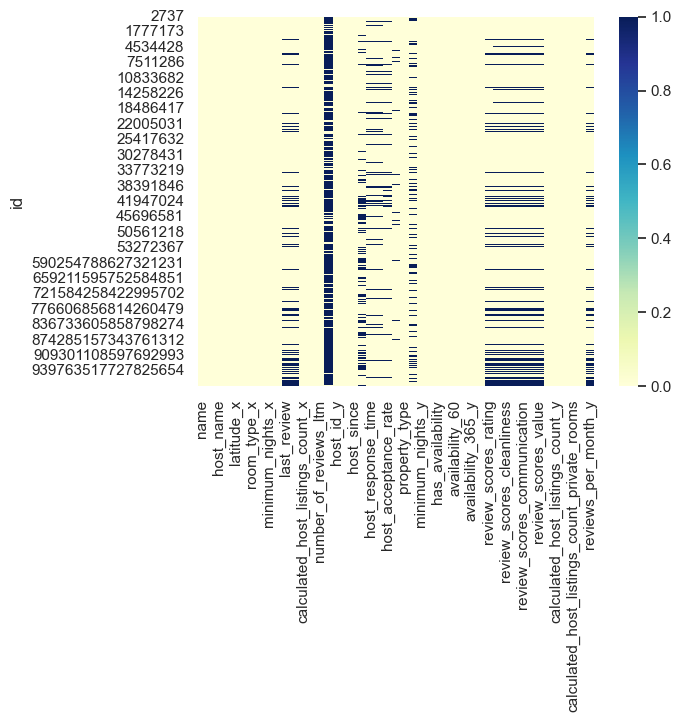

In [14]:
sns.heatmap(data = listings.isna(),cmap="YlGnBu", )

In [15]:
# Dejaremos sin arreglar los NaN  y no eliminaremos ningún dato para tener el máximo número de alojamientos disponibles, 
# los datos faltantes en las reviews se deben a que nohacen recibido niguna, así que lo dejaremos tal cual están.

In [16]:
listings.drop_duplicates(inplace=True)

In [70]:
title = "Number of listings by neighbourhood"
figura = listings['neighbourhood'].value_counts().sort_values(ascending=True)
px.bar(figura,title=title,  template='plotly_white',orientation='h')



In [18]:
# Hacemos un mapa con todos los alojamientos de Roma, cada color indica el tipo de alojamiento y el tamaño depende de su precio
review = listings.dropna(subset='review_scores_rating')
px.scatter_mapbox(review, lat='latitude_x', lon='longitude_x', size='price_x', zoom=10, mapbox_style='carto-positron', title='AirBnb Apartment Distribution in Roma', template= "plotly_dark", size_max=20, color='room_type_x', hover_name='name')

In [19]:
listings.columns

Index(['name', 'host_id_x', 'host_name', 'neighbourhood', 'latitude_x',
       'longitude_x', 'room_type_x', 'price_x', 'minimum_nights_x',
       'number_of_reviews_x', 'last_review', 'reviews_per_month_x',
       'calculated_host_listings_count_x', 'availability_365_x',
       'number_of_reviews_ltm', 'license', 'host_id_y', 'accommodates',
       'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'property_type', 'bedrooms', 'minimum_nights_y', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365_y', 'number_of_reviews_y',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count_y',
       'calculated_host_listings_cou

In [20]:
# Agrupamos los alojamientos escogiendo solo los de 2 personas, que son los más comunes.

feq2 = listings[listings['accommodates']==2]

feq2 = feq2.groupby('neighbourhood')['price_x'].mean().sort_values(ascending=True)

In [21]:
feq2 = pd.DataFrame(feq2)
feq2

price_x
neighbourhood                         
VI Roma delle Torri          72.890000
XI Arvalia/Portuense         79.171271
VIII Appia Antica            93.507407
XIV Monte Mario              94.372222
III Monte Sacro              94.886076
XII Monte Verde              95.177874
V Prenestino/Centocelle      96.705776
VII San Giovanni/Cinecittà  100.228412
X Ostia/Acilia              102.155000
XV Cassia/Flaminia          105.247126
IX Eur                      108.752381
IV Tiburtina                113.257143
XIII Aurelia                119.299048
II Parioli/Nomentano        180.191520
I Centro Storico            188.610032

In [22]:
adam = gpd.read_file("input/neighbourhoods.geojson")
# Asegurarse de que 'feq' es un DataFrame de pandas correcto antes de transponerlo
# Si 'feq' es un DataFrame, no necesitamos encapsularlo en una lista y convertirlo a DataFrame otra vez

# Mezclamos
adam = pd.merge(adam, feq2, on='neighbourhood', how='left')


In [23]:
# Renombramos la columna
adam.rename(columns={'price_x': 'average_price'}, inplace=True)
adam

neighbourhood  neighbourhood_group  \
0             I Centro Storico                  NaN   
1              III Monte Sacro                  NaN   
2                 IV Tiburtina                  NaN   
3          VI Roma delle Torri                  NaN   
4   VII San Giovanni/Cinecittà                  NaN   
5            VIII Appia Antica                  NaN   
6                       IX Eur                  NaN   
7               X Ostia/Acilia                  NaN   
8         XI Arvalia/Portuense                  NaN   
9              XII Monte Verde                  NaN   
10                XIII Aurelia                  NaN   
11             XIV Monte Mario                  NaN   
12          XV Cassia/Flaminia                  NaN   
13     V Prenestino/Centocelle                  NaN   
14        II Parioli/Nomentano                  NaN   

                                             geometry  average_price  
0   MULTIPOLYGON (((12.44396 41.93390, 12.44472 41...     188.610032  
1   MULTIPOLYGON (((12.56321 42.07464, 12.56269 42...      94.886076  
2   MULTIPOLYGON (((12.63542 41.95729, 12.63696 41...     113.257143  
3   MULTIPOLYGON (((12.70671 41.93375, 12.70691 41...      72.890000  
4   MULTIPOLYGON (((12.51668 41.89194, 12.52266 41...     100.228412  
5   MULTIPOLYGON (((12.48108 41.87642, 12.48137 41...      93.507407  
6   MULTIPOLYGON (((12.47554 41.84734, 12.47616 41...     108.752381  
7   MULTIPOLYGON (((12.35255 41.80295, 12.35351 41...     102.155000  
8   MULTIPOLYGON (((12.28997 41.82954, 12.28645 41...      79.171271  
9   MULTIPOLYGON (((12.25065 41.87581, 12.24905 41...      95.177874  
10  MULTIPOLYGON (((12.30750 41.96183, 12.30996 41...     119.299048  
11  MULTIPOLYGON (((12.29248 42.03120, 12.29396 42...      94.372222  
12  MULTIPOLYGON (((12.34895 42.10263, 12.35080 42...     105.247126  
13  MULTIPOLYGON (((12.61538 41.89946, 12.61529 41...      96.705776  
14  MULTIPOLYGON (((12.50098 41.94215, 12.50117 41...     180.191520

In [24]:
import branca.colormap as cm

In [25]:
# Redondeamos el precio
adam['average_price'] = adam['average_price'].round(decimals=2)

# Conseguimos colores para nuestras casas 
map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = cm.linear.YlOrRd_07.scale(vmin = min(map_dict.values()), vmax = max(map_dict.values()))
def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    if value is not None:
        return color_scale(value)
    else:
        return 'grey'  # Un color predeterminado si el barrio no está en el diccionario

In [26]:

# Hacemos el mapa
map3 = folium.Map(location=[41.902652, 12.484885], zoom_start=11)
folium.GeoJson(data=adam,
               name='Roma',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.55
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.9}).add_to(map3)
map3

In [27]:
listings.columns

Index(['name', 'host_id_x', 'host_name', 'neighbourhood', 'latitude_x',
       'longitude_x', 'room_type_x', 'price_x', 'minimum_nights_x',
       'number_of_reviews_x', 'last_review', 'reviews_per_month_x',
       'calculated_host_listings_count_x', 'availability_365_x',
       'number_of_reviews_ltm', 'license', 'host_id_y', 'accommodates',
       'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'property_type', 'bedrooms', 'minimum_nights_y', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365_y', 'number_of_reviews_y',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count_y',
       'calculated_host_listings_cou

In [43]:
df_corr = listings[['neighbourhood', 'room_type_x', 'price_x', 'number_of_reviews_x','number_of_reviews_ltm',
       'accommodates','host_response_rate', 'host_acceptance_rate', 'host_is_superhost','property_type', 
       'bedrooms','review_scores_rating', 'instant_bookable']]
df_corr.head()

neighbourhood      room_type_x  price_x  number_of_reviews_x  \
id                                                                            
2737       VIII Appia Antica     Private room       75                    7   
3079        I Centro Storico  Entire home/apt       90                   21   
11834       I Centro Storico  Entire home/apt      105                  203   
103245      I Centro Storico  Entire home/apt      110                  389   
12398   II Parioli/Nomentano  Entire home/apt      121                   59   

        number_of_reviews_ltm  accommodates  host_response_rate  \
id                                                                
2737                        0             1                98.0   
3079                        0             4               100.0   
11834                      46             2               100.0   
103245                     77             6               100.0   
12398                      15             6               100.0   

       host_acceptance_rate host_is_superhost       property_type  bedrooms  \
id                                                                            
2737                     3%                 f        Private room       NaN   
3079                    10%                 t  Entire rental unit       1.0   
11834                  100%                 t  Entire rental unit       1.0   
103245                 100%                 t  Entire rental unit       2.0   
12398                   82%                 t  Entire rental unit       2.0   

        review_scores_rating instant_bookable  
id                                             
2737                    4.80                f  
3079                    4.53                f  
11834                   4.81                f  
103245                  4.87                t  
12398                   4.91                f

In [44]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_corr['neighbourhood'])
df_corr['neighbourhood'] = le.transform(df_corr['neighbourhood'])

In [45]:
le = LabelEncoder()
le.fit(df_corr['room_type_x'])
df_corr['room_type_x'] = le.transform(df_corr['room_type_x'])

In [46]:
le = LabelEncoder()
le.fit(df_corr['property_type'])
df_corr['property_type'] = le.transform(df_corr['property_type'])

In [47]:
df_corr.head()

neighbourhood  room_type_x  price_x  number_of_reviews_x  \
id                                                                 
2737                8            2       75                    7   
3079                0            0       90                   21   
11834               0            0      105                  203   
103245              0            0      110                  389   
12398               1            0      121                   59   

        number_of_reviews_ltm  accommodates  host_response_rate  \
id                                                                
2737                        0             1                98.0   
3079                        0             4               100.0   
11834                      46             2               100.0   
103245                     77             6               100.0   
12398                      15             6               100.0   

       host_acceptance_rate host_is_superhost  property_type  bedrooms  \
id                                                                       
2737                     3%                 f             26       NaN   
3079                    10%                 t             18       1.0   
11834                  100%                 t             18       1.0   
103245                 100%                 t             18       2.0   
12398                   82%                 t             18       2.0   

        review_scores_rating instant_bookable  
id                                             
2737                    4.80                f  
3079                    4.53                f  
11834                   4.81                f  
103245                  4.87                t  
12398                   4.91                f

In [48]:
corr_matrix= df_corr.corr(method = 'pearson').sort_values(by = 'price_x', axis = 0, ascending = False).sort_values(by = 'price_x', axis = 1, ascending = False)
corr_matrix

price_x  accommodates  bedrooms  host_response_rate  \
price_x                1.000000      0.123387  0.103206           -0.003448   
accommodates           0.123387      1.000000  0.737580            0.037877   
bedrooms               0.103206      0.737580  1.000000            0.002546   
host_response_rate    -0.003448      0.037877  0.002546            1.000000   
review_scores_rating  -0.018593      0.020134  0.001411            0.189496   
property_type         -0.025454     -0.378699 -0.097476           -0.093282   
number_of_reviews_x   -0.032633      0.016609 -0.032069            0.121100   
number_of_reviews_ltm -0.038732      0.017370 -0.044605            0.185973   
room_type_x           -0.042788     -0.437152 -0.128918           -0.114124   
neighbourhood         -0.052649     -0.041948 -0.021324           -0.025419   

                       review_scores_rating  property_type  \
price_x                           -0.018593      -0.025454   
accommodates                       0.020134      -0.378699   
bedrooms                           0.001411      -0.097476   
host_response_rate                 0.189496      -0.093282   
review_scores_rating               1.000000      -0.092064   
property_type                     -0.092064       1.000000   
number_of_reviews_x                0.093523      -0.068258   
number_of_reviews_ltm              0.130321      -0.137175   
room_type_x                       -0.081690       0.820969   
neighbourhood                      0.008071      -0.017530   

                       number_of_reviews_x  number_of_reviews_ltm  \
price_x                          -0.032633              -0.038732   
accommodates                      0.016609               0.017370   
bedrooms                         -0.032069              -0.044605   
host_response_rate                0.121100               0.185973   
review_scores_rating              0.093523               0.130321   
property_type                    -0.068258              -0.137175   
number_of_reviews_x               1.000000               0.696737   
number_of_reviews_ltm             0.696737               1.000000   
room_type_x                      -0.109615              -0.139259   
neighbourhood                    -0.149588              -0.154291   

                       room_type_x  neighbourhood  
price_x                  -0.042788      -0.052649  
accommodates             -0.437152      -0.041948  
bedrooms                 -0.128918      -0.021324  
host_response_rate       -0.114124      -0.025419  
review_scores_rating     -0.081690       0.008071  
property_type             0.820969      -0.017530  
number_of_reviews_x      -0.109615      -0.149588  
number_of_reviews_ltm    -0.139259      -0.154291  
room_type_x               1.000000       0.009420  
neighbourhood             0.009420       1.000000

In [51]:
mask =np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.color_palette("coolwarm", as_cmap=True)

<AxesSubplot: >

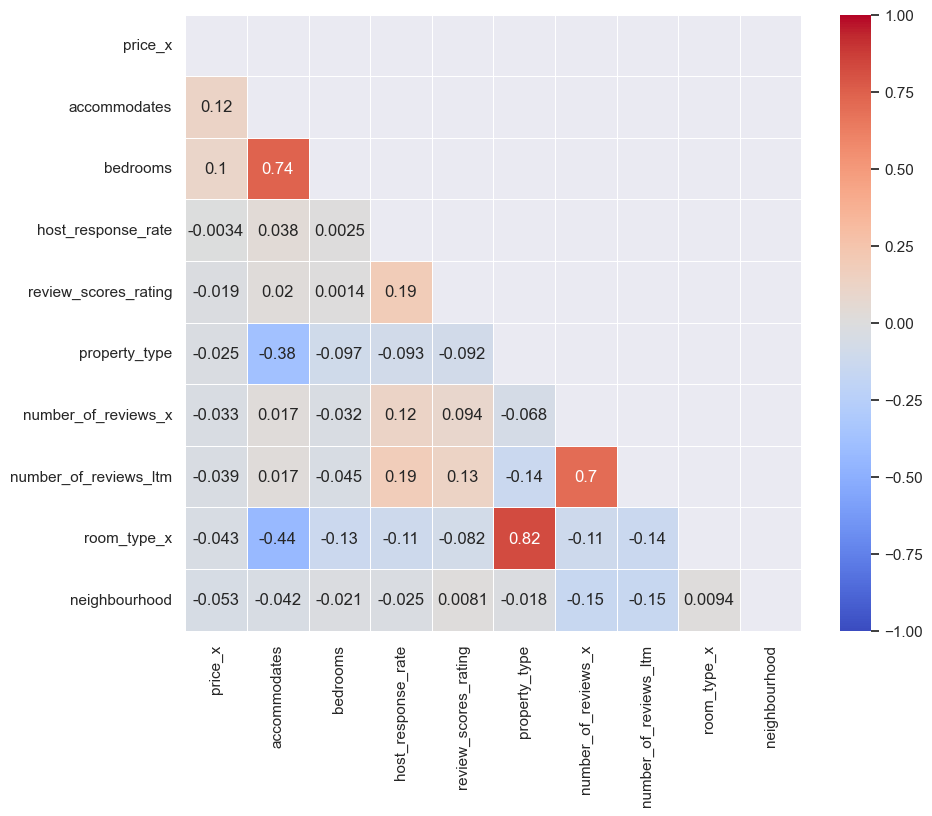

In [52]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True)